<img src="gcd.png" align="right" style="float" width="100">
<img src="logo_UV.jpg"  align="right" style="float" width="200">



<font color="#CA3532"><h1 align="left">Data Science Dregree.</h1></font>
<font color="#6E6E6E"><h2 align="left">Session 3. SVM for classification </h2></font> 



#### Yolanda Vives Gilabert, Álvaro Moreno Martínez, Marcelino Martínez Sober

#### Objective

The objective of this practice is to illustrate how the hyperparameters of a classifier, such as the **SVM**, can be tuned in a binary classification problem, and subsequently it will be shown how it can be generalized to a multiclass problem.

In this link there is a simple explanation about SVM 
https://www.cienciadedatos.net/documentos/34_maquinas_de_vector_soporte_support_vector_machines

In [1]:
# Autoreload of packages
%load_ext autoreload
%autoreload 2
# Graphics inserted in document
%matplotlib inline 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from sklearn.svm import SVC # support vector classifier
from sklearn.datasets import make_moons, load_iris
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.decomposition import PCA

#### We will use a "toy" example to illustrate how SVM works and how hyperparameters influence it.

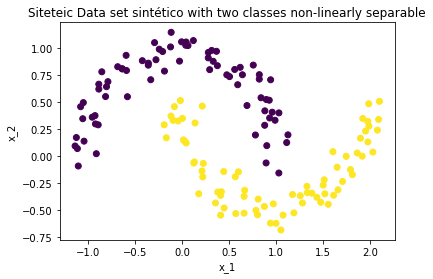

In [3]:
# We generate the data, represent them
X, y = make_moons(n_samples=150, noise=0.1) # include random_state for repetetivity

fig,ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], c=y)
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_title('Siteteic Data set sintético with two classes non-linearly separable')

# We divide our data into training and test data from the start
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=1/3)

#### Data normalization

The SVM training algorithm is quite sensitive to the range of the data, and can give stability problems in case the input data (the $X$) are not properly normalized.

To avoid such problems and improve the results, the first step to be taken when working with SVMs is to normalize the data. The normalizations that provide the best results are obtained by scaling the data between 0 and 1 (or between -1 and 1), or normalizing by subtracting the mean and dividing by the standard deviation (standardization).

For this first "toy" example with which we are going to start **we are not** going to perform this step since the data are already in an appropriate scale of values (practically between -1 and 1). However, keep in mind that it is normal to normalize as a first step.

For more information about SVM in general and about this scaling issue in particular you should read this document: https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf.


#### First we will show how the nonlinear separation boundary changes as the kernel scale varies

A *kernel* is a transformation that maps the original data into a new high-dimensional space that offers special features for solving a given problem.

We will use the RBF (Radial Basis Function) kernel which is probably the most widely used kernel for solving nonlinear classification problems. Its definition is
$$ k(x_1,x_2) = \exp\left(\frac{\|x_1-x_2\|^2}{2\sigma^2}\right) $$
where $\sigma^2$ defines the width (or scale) of ths function.

This hyperparameter $\sigma^2$ is key to determine the behavior of the SVM in nonlinear problems, since it is the one that determines the high-dimensional space to which we implicitly map the samples of the original space, $x$, to the feature space by means of a function $\varphi$ whose explicit expression is, in principle, unknown.

In the scikit-learn implementation the RBF kernel is defined by $k(x_1,x_2) = \exp(\gamma\|x_1-x_2\|^2)$, by substituting the parameter $\sigma$ by another related by the expression $\gamma=\frac{1}{2\sigma^2}$.

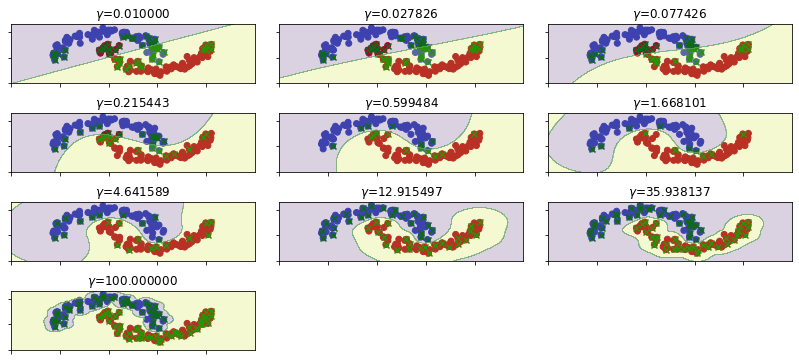

In [4]:
h = 0.01
xrange = np.arange(-2, 3, h)
yrange = np.arange(-1, 1.3, h)

#np.meshgrid generates an array of coordinates for evaluating level surfaces
xx, yy = np.meshgrid(xrange, yrange)


#np.c_ arranges two one-dimensional arrays in columns.
#.ravel arranges an NxM array into a one-dimensional array of size 1xN*M.
zz = np.c_[xx.ravel(), yy.ravel()]

plt.figure(figsize=(14,6))
C = 10
#np.logspace generates an array of 10 samples between 10**-2 and 10**2 logarithmically distributed.
gammas = np.logspace(-2, 2, 10)

for n, gamma in enumerate(gammas):
    #SVC Function defining the SVM in scikitlearn
    svc = SVC(kernel='rbf', gamma=gamma, C=C)
    #We train the svm with train data
    svc.fit(Xtrain, ytrain)
    Z = svc.predict(zz)
    Z = Z.reshape(xx.shape)
    # Draw
    ax = plt.subplot(4, 3, n+1)
    #Draw the dataset, with the color as the class Blue=1 Red=0
    plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.coolwarm)
    #We draw the support vectors as green crosses using the attribute support_vectors_
    plt.scatter(svc.support_vectors_[:,0], svc.support_vectors_[:,1],\
                c='g', marker='x')
    
    #We draw the separation boundary, as a function of Gamma, sigma
    plt.contourf(xx, yy, Z, alpha=0.2)
    plt.title(r'$\gamma$=%f' % gamma)
    plt.setp(ax, xticklabels=[], yticklabels=[])
plt.subplots_adjust(wspace=0.1, hspace=0.5)    

**Exercise** Repeat the previous section setting $\gamma=5$ and varying C. For *C* use 12 values with logarithmic spacing between 0.01 and 1000.

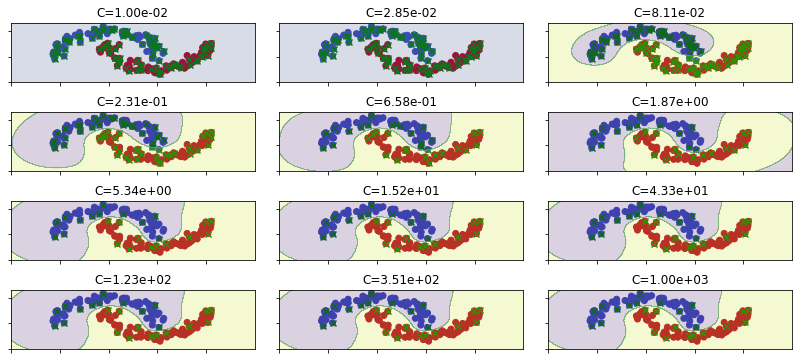

In [5]:
# Create a list of 12 logarithmically spaced C values between 0.01 and 1000
C_values = np.logspace(-2, 3, 12)

plt.figure(figsize=(14, 6))
gamma = 5  # Fixed gamma value

for n, C in enumerate(C_values):
    svc = SVC(kernel='rbf', gamma=gamma, C=C)
    svc.fit(Xtrain, ytrain)
    Z = svc.predict(zz)
    Z = Z.reshape(xx.shape)
    ax = plt.subplot(4, 3, n + 1)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
    plt.scatter(svc.support_vectors_[:, 0], svc.support_vectors_[:, 1], c='g', marker='x')
    plt.contourf(xx, yy, Z, alpha=0.2)
    plt.title(f'C={C:.2e}')
    plt.setp(ax, xticklabels=[], yticklabels=[])
    
plt.subplots_adjust(wspace=0.1, hspace=0.5)
plt.show()

#### Choosing the optimum hyperparameters

As we have just seen the free parameters of the SVM (also called hyperparameters) are key to the proper functioning of the algorithm. The question that follows logically is how do we find out which are the best ones?

There are several ways to attack the problem but usually we have to do a sweep where we try several values and we are left with the best combination. Still, how do we set the range of values to test?

The parameter *C* allows to adjust how much the errors made by the classifier are penalized. Low values of C allow more errors, high values strongly penalize errors. Too low values may result in so few errors being penalized that the model is not trained correctly. Conversely, high values penalize errors so much that the model learns the data "by heart", being unable to generalize and predict correctly on unseen data (over-training, or *overfitting*). In general we can test between values between $10^{-3}$ and $10^3$.

#### The "trick" for RBF kernel scaling

As for the $$sigma$$ of the RBF kernel, to know where to start, one technique is to estimate the average distance between training samples. Since this kernel measures the distance (or difference) between samples, $\|x_1-x_2|^2$, it is logical to use a $$sigma^2$$ value that is on the same order of magnitude. From this empirical value of the value of $$sigma^2$$ you can sweep in a range of between $10^{-2}$ or $10^{-1}$ and $10$ or $100$ times this value. You can use the *pdist* function of *scipy.spatial.distance* to calculate the distance between samples.

#### The sigma trick


In [6]:
#We estimate the average distance in the data set
sigma_mean = np.mean(scipy.spatial.distance.pdist(X)) 
sigma_min = sigma_mean * 0.1 #Between 0.01*mean distance 
sigma_max = sigma_mean * 10 # 100* mena distance


#### Remember that in scikit-learn instead of $sigma$ we have $\gamma = \frac{1}{2\sigma^2}$

In [7]:
# We go form sigma to gamma

gamma_min = np.log10(1/2/sigma_max**2)
gamma_max = np.log10(1/2/sigma_min**2)
print(gamma_min)
print(gamma_max)


-2.5035620385907142
1.4964379614092858


#### Testing different combinations of parameters

Determining the parameter ranges to test is the first step, but now the question is how to test them properly.

Recall that we only have one training set, in our case `Xtrain` and `ytrain`, and that we should not use the test set to train the model since this set should only be used to test the final model.

One option could be to train with the whole training set and validate on it, but by doing this we run a high risk of over-training the model to the training data, undermining its generalization capabilities.

To avoid this problem we will again subdivide the training set to have separate training and validation sets to evaluate the performance of each hyperparameter combination. We can use any of the techniques seen in the previous practice, *hold-out*, *k-fold*, etc. For this example we will use *k-fold* with $k=5$.

**Important note**: notice that in the previous practice we used the set splitting techniques only to test the model. In this practice we will use *hold-out* to test the final model (as in the previous practice) and *k-fold* to adjust the free parameters.

**Exercise:** complete the following code.

Consider 10 values, with logarithmic spacing, for defining $\gamma$.

In [8]:
from sklearn.metrics import accuracy_score

# STUDENT CODE
# We define the range
npoints = 10

gammas = np.logspace(gamma_min, gamma_max, npoints)
Cs = np.logspace(-3, 3, 7) #Recommended values

# We define the k-fold
kfold = KFold(n_splits=5)

# We test each combination in each subset of training and testing
accuracies = []
n = 1
for itrain, itest in kfold.split(Xtrain):
    print('kfold %d ...' % n)
    n += 1
    for gamma in gammas:
        for C in Cs:
             # We create the model
            svc = SVC(kernel='rbf', gamma=gamma, C=C)
            
            # Train the model using Xtrain and ytrain with the current fold indices
            svc.fit(Xtrain[itrain], ytrain[itrain])
            
            acc = svc.score(Xtrain[itest], ytrain[itest])
            
            # Append the accuracy to the list
            accuracies.append(acc)
            
print(accuracies)

kfold 1 ...
kfold 2 ...
kfold 3 ...
kfold 4 ...
kfold 5 ...
[0.75, 0.75, 0.75, 0.75, 0.8, 0.85, 0.85, 0.75, 0.75, 0.75, 0.75, 0.8, 0.85, 0.85, 0.75, 0.75, 0.75, 0.8, 0.85, 0.9, 0.85, 0.75, 0.75, 0.75, 0.8, 0.85, 0.9, 1.0, 0.8, 0.8, 0.8, 0.85, 1.0, 1.0, 1.0, 0.8, 0.8, 0.8, 1.0, 1.0, 1.0, 1.0, 0.9, 0.9, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.65, 0.65, 0.65, 0.65, 0.75, 0.75, 0.75, 0.65, 0.65, 0.65, 0.65, 0.75, 0.75, 0.75, 0.65, 0.65, 0.65, 0.75, 0.75, 0.75, 0.8, 0.65, 0.65, 0.65, 0.75, 0.75, 0.8, 1.0, 0.65, 0.65, 0.65, 0.75, 0.8, 1.0, 0.95, 0.75, 0.75, 0.75, 0.85, 1.0, 1.0, 1.0, 0.8, 0.8, 0.8, 1.0, 1.0, 1.0, 1.0, 0.9, 0.9, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.35, 0.35, 0.35, 0.35, 0.85, 0.9, 0.9, 0.35, 0.35, 0.35, 0.85, 0.9, 0.9, 0.85, 0.35, 0.35, 0.35, 0.9, 0.9, 0.9, 0.9, 0.35, 0.35, 0.35, 0.9, 0.9, 0.9, 1.0, 0.35, 0.35, 0.9, 0.9, 0.9, 

In [9]:
# We look for the combination that has given us the best result
# in the tests

accuracies = np.array(accuracies).reshape((5, npoints, 7))
macc = np.mean(accuracies, axis=0)
idx = np.unravel_index(np.argmax(macc), macc.shape)
best_gamma, best_C = gammas[idx[0]], Cs[idx[1]]
print('Best gamma:', best_gamma, 'best C:', best_C, 'Higest accuracy:', macc[idx[0], idx[1]])

Best gamma: 0.5231909024699825 best C: 100.0 Higest accuracy: 1.0


We now train the model with the optimal parameters with the entire training set, and represent the class separation boundaries.

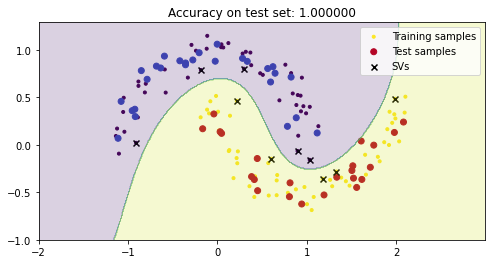

In [10]:
# Train the final model using the best gamma and C combo
svc = SVC(kernel='rbf', gamma=best_gamma, C=best_C)
svc.fit(Xtrain, ytrain)
# Accuracy on test set
acc = svc.score(Xtest, ytest)
# Represent
Z = svc.predict(zz).reshape(xx.shape)
plt.figure(figsize=(8,4))
plt.scatter(Xtrain[:,0], Xtrain[:,1], c=ytrain, marker='.', label='Training samples')
plt.scatter(Xtest[:,0], Xtest[:,1], c=ytest, marker='o', cmap=plt.cm.coolwarm, \
            label='Test samples')
plt.scatter(svc.support_vectors_[:,0], svc.support_vectors_[:,1], c='black', \
            marker='x', label='SVs')
plt.contourf(xx, yy, Z, alpha=0.2)
plt.legend(), plt.title('Accuracy on test set: %f' % acc);

#### Classification problems of more than two classes
The SVM is by nature a binary classifier that defines the hyperplane (the boundary) separating two classes. To solve problems where we have to classify more than two classes, two main strategies are used:

1. OVR (one-vs-rest), or one-vs-rest. Here what is done is to train a classifier for each existing class and pit it against the rest of the grouped classes. To predict, the sample to be classified is passed through each of the trained models and the class that obtains the highest classification score (probability) is assigned.

2. OVO (one-vs-one), or one against the other. Here if we have $C$ classes we train $C(C-1)/2$ models that decide between each pair of classes. To predict we use all the trained models and again the top ranked class is chosen.


There are papers in the literature showing that there are no significant differences in the results obtained by these two strategies (see https://www.csie.ntu.edu.tw/~cjlin/papers/multisvm.pdf).

By default scikit-learn SVMs use OVR, although we advise you to always read the documentation because this can change.

**Exercise**: list the advantages and disadvantages that you believe the OVR and OVO strategies have.


#### OVR:
##### Advantages:
- Simplicity: OVR is simpler to implement and computationally less expensive compared to OVO. It involves training only one classifier per class.
- Efficiency: Training many binary classifiers in parallel is often more efficient than training individual classifiers for each pair of classes.
- Imbalanced Classes: It handles imbalanced class distributions well since each classifier is trained to distinguish one class from the rest.

##### Disadvantages:
- Imbalanced Data: OVR can be sensitive to imbalanced datasets, especially when some classes have significantly fewer examples than others.
-  In cases where decision boundaries between classes are ambiguous, the OVR strategy might struggle.


#### OVO:
##### Advantages:
- Robustness: OVO tends to be more robust in situations where the classes are not well-separated, and the decision boundaries are complex.
- Imbalanced Data: OVO can perform well on imbalanced datasets since it trains binary classifiers on balanced subsets of the data.

##### Disadvantages:
- Computational Cost: can be computationally expensive for a large number of classes.
- Scalability: The training time and memory requirements increase quadratically with the number of classes.

#### To illustrate the multiclass problem, we will work again with the IRIS dataset and test the OVO strategy.

In [11]:
X, y = load_iris(return_X_y=True)

**Exercise.** Split X and y using hold-out (2/3 train, 1/3 test).

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)

**Exercise.** Reduce the dimensionality of the $X$ to only two components using PCA and visualize the data in principal component space (PC2 vs. PC1), coloring according to class.

In [13]:
pca = PCA(n_components=2)
Xt = pca.fit_transform(X)

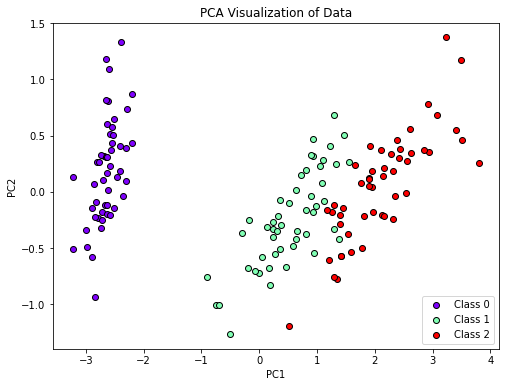

In [14]:
# We visualize the classes in the space of principal components
plt.figure(figsize=(8, 6))
classes = np.unique(y)
colors = plt.cm.rainbow(np.linspace(0, 1, len(classes)))
for i, label in enumerate(classes):
    class_data = Xt[y == label]
    plt.scatter(class_data[:, 0], class_data[:, 1], label=f'Class {label}', c=[colors[i]], edgecolor='k')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Visualization of Data')
plt.legend()
plt.show()

#### GridSearchCV
To train the models we will again resort to k-fold, but this time we will use scikit-learn's `GridSearchCV` function to automate the process.

This function takes a scikit-learn model and a set of parameters and automatically performs the process of fitting them using a k-fold. Relevant parameters:
- The model to train.
- The parameter grid to use (*param_grid*).
- cv`: in $k$ number of *folds* to use. We will use 5.
- `verbose`: to provide more or less information.
- `n_jobs`: number of suprocesses to use for training. This decreases very significantly the training time needed in systems with several processors.

In [15]:
# We create the three needed model for implementing OVO
sigma_mean = np.mean(scipy.spatial.distance.pdist(Xtrain))
gamma_mean = 1/2/sigma_mean**2
param_grid = [{
    'C': np.logspace(-3, 3, 7),
    'gamma': np.logspace(np.log10(gamma_mean*0.1), np.log10(gamma_mean*10), 20),
    'kernel': ['rbf']
}]
gcv1 = GridSearchCV(SVC(), param_grid=param_grid, cv=5, verbose=1, n_jobs=2)
gcv2 = GridSearchCV(SVC(), param_grid=param_grid, cv=5, verbose=0, n_jobs=2)
gcv3 = GridSearchCV(SVC(), param_grid=param_grid, cv=5, verbose=0, n_jobs=2)

**Train classifiers gcv1, gcv2 and gcv3 for classes 0 and 1, 0 and 2 and 1 and 2, respectively.

In [16]:
# Clases 0 y 1
class_indices = np.where((y_train == 0) | (y_train == 1))
X_subset = X_train[class_indices]
y_subset = y_train[class_indices]
gcv1.fit(X_subset, y_subset)

print(f"Best parameters for classes 0, 1: {gcv1.best_params_}")


Fitting 5 folds for each of 140 candidates, totalling 700 fits
Best parameters for classes 0, 1: {'C': 0.1, 'gamma': 0.03183146258829511, 'kernel': 'rbf'}


In [17]:
# Clases 0 y 2
class_indices = np.where((y_train == 0) | (y_train == 2))
X_subset = X_train[class_indices]
y_subset = y_train[class_indices]
gcv2.fit(X_subset, y_subset)

print(f"Best parameters for classes 0, 2: {gcv1.best_params_}")

Best parameters for classes 0, 2: {'C': 0.1, 'gamma': 0.03183146258829511, 'kernel': 'rbf'}


In [18]:
# Clases 1 y 2
class_indices = np.where((y_train == 1) | (y_train == 2))
X_subset = X_train[class_indices]
y_subset = y_train[class_indices]
gcv3.fit(X_subset, y_subset)

print(f"Best parameters for classes 1, 2: {gcv1.best_params_}")

Best parameters for classes 1, 2: {'C': 0.1, 'gamma': 0.03183146258829511, 'kernel': 'rbf'}


**Exercise.** Obtain the predictions of the test set (`Xtest`) in the three trained models.

In [19]:
# Predictions
predicts_gcv1 = gcv1.predict(X_test)
predicts_gcv2 = gcv2.predict(X_test)
predicts_gcv3 = gcv3.predict(X_test)
print(predicts_gcv1)
print(predicts_gcv2)
print(predicts_gcv3)

[1 0 1 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 1 1 0 0 0 0 1 0 0 1 1
 0 0 0 1 1 1 0 0 1 1 1 1 1]
[2 0 2 2 2 0 2 2 2 2 2 0 0 0 0 2 2 2 2 2 0 2 0 2 2 2 2 2 0 0 0 0 2 0 0 2 2
 0 0 0 2 2 2 0 0 2 2 2 2 2]
[1 1 2 1 1 1 1 2 1 1 2 1 1 1 1 1 2 1 1 2 1 2 1 2 2 2 2 2 1 1 1 1 1 1 1 2 1
 1 1 1 2 1 1 1 1 1 2 2 1 2]


**Exercise.** Using ``scipy.stats.mode`` (the mode) get the highest rated class.

In [20]:
all_predictions = np.array([predicts_gcv1, predicts_gcv2, predicts_gcv3])

# Use scipy.stats.mode to get the mode along axis 0
mode_result = scipy.stats.mode(all_predictions)

# The mode_result.mode contains the highest rated class
highest_rated_class = mode_result.mode[0]

print("Highest Rated Class:", highest_rated_class)

Highest Rated Class: [1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0 0 0 2 1 1 0 0 1 2 2 1 2]


#### Comparison with scikit-learn's OVO
By default the scikit-learn SVCs implement the OVR strategy.

In [21]:
# SVC already performs OVR (one-vs-rest) or OVO (one-vs-one) for you
param_grid = [{
    'C': np.logspace(-3, 3, 7),
    'gamma': np.logspace(np.log10(gamma_mean*0.1), np.log10(gamma_mean*10), 20),
    'kernel': ['rbf'],
    'decision_function_shape': ['ovo']
}]
gcv = GridSearchCV(SVC(), param_grid=param_grid, cv=5, verbose=1, n_jobs=2)

**Exercise**. Train the classifier and get its *score*.

In [22]:
gcv.fit(X_train, y_train)

Fitting 5 folds for each of 140 candidates, totalling 700 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=2,
             param_grid=[{'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                          'decision_function_shape': ['ovo'],
                          'gamma': array([0.03183146, 0.04056204, 0.05168719, 0.06586369, 0.08392845,
       0.10694793, 0.13628107, 0.17365956, 0.22129003, 0.28198436,
       0.35932561, 0.45787964, 0.58346457, 0.74349431, 0.9474162 ,
       1.20726876, 1.53839238, 1.96033493, 2.49800576, 3.18314626]),
                          'kernel': ['rbf']}],
             verbose=1)

In [23]:
gcv.score(X_test, y_test)

1.0

**Represent the separation boundaries for the multiclass problem.

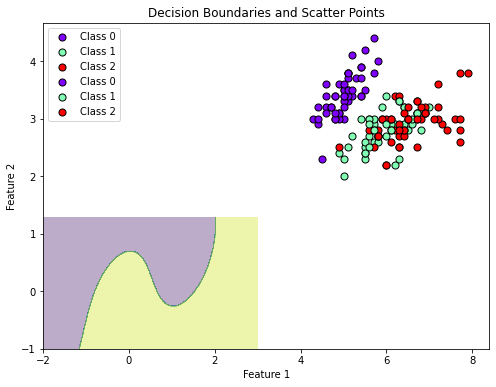

In [33]:
def plot_decision_boundaries(X, y, model, ax):    
    if X.shape[1] > 2:
        additional_features = np.zeros((xx.size, X.shape[1] - 2))

    ax.contourf(xx, yy, Z, alpha=0.2)
    
    classes = np.unique(y)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(classes)))
    for i, label in enumerate(classes):
        class_data = X[y == label]
        ax.scatter(class_data[:, 0], class_data[:, 1], label=f'Class {label}', c=[colors[i]], edgecolor='k', s=50)


fig, ax = plt.subplots(figsize=(8, 6))
plot_decision_boundaries(X_train, y_train, gcv, ax)
plot_decision_boundaries(X_test, y_test, gcv, ax)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision Boundaries and Scatter Points')
plt.legend()
plt.show()


**Exercise**.
Implement the OVR strategy for the 3-class problem and compare your results with the SVC using `decision_function_shape='ovr'`. The figure below shows this strategy graphically.
![ovr.png](ovr.png)


In [ ]:
param_grid = [{
    'C': np.logspace(-3, 3, 7),
    'gamma': np.logspace(np.log10(gamma_mean*0.1), np.log10(gamma_mean*10), 20),
    'kernel': ['rbf'],
}]
gcv = GridSearchCV(SVC(), param_grid=param_grid, cv=5, verbose=1, n_jobs=2)

In [ ]:
gcv.fit(X_train, y_train)

In [ ]:
gcv.score(X_test, y_test)

**Extra points !!**


Once the optimal parameters for the svm in classification have been determined, a new finer sweep is performed again using as limits those of the section corresponding to the ends of the intervals containing the best combination of parameters.



In [ ]:
best_params = {'C': gcv1.best_params_['C'], 'gamma': gcv1.best_params_['gamma'], 'kernel': 'rbf'}
print(best_params)

C_range = np.logspace(np.log10(best_params['C']) - 1, np.log10(best_params['C']) + 1, 10)
gamma_range = np.logspace(np.log10(best_params['gamma']) - 1, np.log10(best_params['gamma']) + 1, 10)
kernel_options = ['rbf']

param_grid_finer = [{'C': C_range, 'gamma': gamma_range, 'kernel': kernel_options}]

svm_finer = SVC()
grid_search_finer = GridSearchCV(svm_finer, param_grid=param_grid_finer, cv=5, n_jobs=-1)
grid_search_finer.fit(X_train, y_train)

# Get the best parameters from the finer grid search
best_params_finer = grid_search_finer.best_params_


print("Best Parameters from Finer Grid Search:", best_params_finer)
print("Best Cross-validated Score from Finer Grid Search:", grid_search_finer.best_score_)
